In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import math
from scipy.interpolate import interp1d
import seaborn as sns
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.mlab import griddata
from datetime import datetime
from scipy import stats


In [17]:
############### Synthetic Data #############
# β = 0.005
# μ1 = 1/21 #14 days infectious
# μ2 = 1/5 #5 days (14 - 9 days)
# σ =1/5 #5 days exposed
# ω=1/9 # 9 days until emitted to hospital
# ϵ = 0.0001
# pp = 0.7
capT = 1000
# γ = 1/(80*365)
Input_H = [1500,1,0,0]
parameters = [Input_H, capT] 

In [18]:
def gillespieSEIR(initial, beta, mu1,mu2, sigma, epsilon,  max_time):
    event_time = []
    pop = []
    N = sum(initial)
    pop.append(initial)
    event_time.append(0)
    times = 0
    ind = 0
    cuminf = []
    cuminf.append(0)
    events = []
    while times <max_time and (pop[ind][1]+pop[ind][2]>0):
        state = np.zeros(shape= (4,4))
        
        ####################################################################################
        #################################### EVENTS ########################################
        ####################################################################################
        
        
        R_se = beta*(pop[ind][0])*(pop[ind][2])/N + epsilon*pop[ind][0] 
        state[:,0] = [-1, 1, 0, 0]
        
        R_ei = sigma*pop[ind][1]
        state[:,1] = [0, -1, 1, 0]
        
        R_ir = mu2*pop[ind][2]
        state[:,2] = [0,0,-1,1]

        R_is = mu1*pop[ind][2]
        state[:,3] = [1,0,-1,0]

        
        rate = [R_se, R_ei, R_ir, R_is]

        Rtotal = sum(rate)
#         print(Rtotal)
        delta_t= -np.log(np.random.uniform(0,1))/Rtotal
        P = np.random.uniform(0,1)*Rtotal
        times =times+ delta_t
        event = np.min(np.where(P<=np.cumsum(rate)))
        events.append(event)
        event_time.append(times)
        pop.append(pop[ind]+state[:,event])
        
#         total_inf = sum(cuminf)
        if event == 1:
            cuminf.append(1 + cuminf[ind] )
        else:
            cuminf.append(0 +cuminf[ind])
        ind=ind+1
        N = sum(pop[ind][:3])
    return event_time, np.array(pop), events, cuminf

In [20]:
def returnerror(Gill, sumstat1, sumstat2):
    time = [] #make results of M a step function
    cuminf = [] #steps
    for ind, x in enumerate(Gill[0]):
        if ind < len(Gill[0])-1:
            time.append((Gill[0][ind], Gill[0][ind+1]))
            cuminf.append((Gill[3][ind], Gill[3][ind]))
    time = np.array(time).flatten()
    cuminf = np.array(cuminf).flatten()
    max_inf = max(cuminf)
    max_time = math.ceil(max(time))
#     print(max_inf, max_time, βt, ɛt)
    

    summary_time = sumstat1
#         print(summary_time, max(summary_time[0]), max_time)
    summary_cum = sumstat2
    if max_time> max(summary_time):
        length1 =  np.arange(max(summary_time), max_time +1, 3)
        summary_time = np.append(summary_time, length1)
#         print(summary_time, len( length1))
        summary_cum = np.append(summary_cum, max(sumstat2)*np.ones(len(length1 )))
#         print(summary_cum)
    if max_time < max(summary_time):
        length2 = np.arange(max_time, max(summary_time)+1, 1)
        time = np.append(time,length2)
        cuminf = np.append(cuminf, max_inf*np.ones(len(length2)))
        
    inter_t = np.arange(0, max(summary_time) +1 , 1) #interpolate to daily steps
    inter_cum = np.interp(inter_t, time,cuminf) 
    return np.linalg.norm(summary_cum-inter_cum[summary_time]), inter_t, inter_cum

# Perform ABC on 2010 data

In [4]:
Data_F10=pd.read_csv("../Case_data/2010_faridpur_cases.csv",sep = ',', header = 0)
############################# Spacing ##############################################
date_format = "%d/%m/%y"


def Spacing(dataset):
    record = []
    record.append(datetime.strptime(dataset['Date'][0], date_format).day)
    for i in range(1, len(dataset)):
        record.append(record[i-1]+(datetime.strptime(dataset['Date'][i], date_format)-datetime.strptime(dataset['Date'][i-1], date_format)).days) 
    record = [int(a - record[0]) for a in record]
    return record

Rec_F10=Spacing(Data_F10)
summary = np.array([Rec_F10, Data_F10['CumsumInf'].values])

# Decide initial tolerance 

22.869193252058544


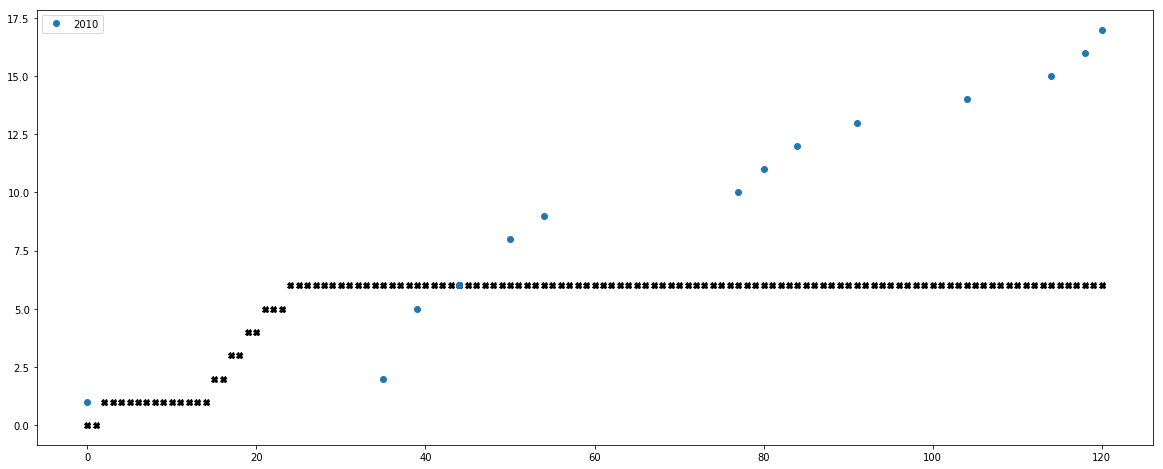

In [37]:
β = 0.005
ϵ = 0.0001
σ = 1/3
μ1 = 1/3
μ2 = 1/10

M =gillespieSEIR(parameters[0], β, μ1,μ2,σ,ϵ,  parameters[1])
time = [] #make results of M a step function
cuminf = [] #steps
for ind, x in enumerate(M[0]):
    if ind < len(M[0])-1:
        time.append((M[0][ind], M[0][ind+1]))
        cuminf.append((M[3][ind], M[3][ind]))
time = np.array(time).flatten()
cuminf = np.array(cuminf).flatten()
max_inf = max(cuminf)
max_time = math.ceil(max(time))
F10 = returnerror(M, summary[0], summary[1])
# F10 = returnerror(M, summary2[0], summary2[1])
# F10+F04

plt.figure(figsize = (20,8))
plt.plot(F10[1], F10[2], 'X',color = 'k')
# plt.plot(Rec_F04, Data_F04['CumsumInf'].values, 'o', label ='2004')
plt.plot(Rec_F10, Data_F10['CumsumInf'].values, 'o', label = '2010')
plt.legend()
# print(F10[0]+F04[0])
print(F10[0])

In [33]:
Input_H

[1500, 1, 0, 0]

In [38]:
N = 100
tol = 23
t = 0 
θ = []

β1, ɛ1, σ1, μ11,μ21 =  [np.random.uniform(0,0.1, N), np.random.uniform(0,0.001, N),
                     1/np.random.uniform(1,30, N), 1/np.random.uniform(1, 40, N),
                     1/np.random.uniform(1,40, N)]
#     print(np.array([β1, ɛ1, p1 ]))

θ = [np.array([β1, ɛ1, σ1, μ11, μ21]).T]
# print(θ[0][:,0])
t = 1
θ_t = []
tols = []
tols.append(tol)
error = []
while t< 6:
    r_β = np.random.randint(0, N-1)
    r_ϵ = np.random.randint(0,N-1)
    r_σ= np.random.randint(0,N-1)
    r_μ1 = np.random.randint(0,N-1)
    r_μ2 = np.random.randint(0,N-1)
    δ = np.random.uniform(0, 1e-3)
    βt, ɛt, σt, μ1t, μ2t = θ[t-1][:,0][r_β] +δ, θ[t-1][:,1][r_ϵ] +δ,θ[t-1][:,2][r_σ] + δ, θ[t-1][:,3][r_μ1] +δ, θ[t-1][:,4][r_μ2] +δ

    M =gillespieSEIR(parameters[0], βt, μ1t,μ2t,σt,ɛt,  parameters[1])
    time = [] #make results of M a step function
    cuminf = [] #steps
    for ind, x in enumerate(M[0]):
        if ind < len(M[0])-1:
            time.append((M[0][ind], M[0][ind+1]))
            cuminf.append((M[3][ind], M[3][ind]))
    time = np.array(time).flatten()
    cuminf = np.array(cuminf).flatten()
    max_inf = max(cuminf)
    max_time = math.ceil(max(time))
#     print(max_inf, max_time, βt, ɛt)
    

    summary_time = summary[0]
#         print(summary_time, max(summary_time[0]), max_time)
    summary_cum = summary[1]
    if max_time> max(summary_time):
        length1 =  np.arange(max(summary_time), max_time +1, 3)
        summary_time = np.append(summary_time, length1)
#         print(summary_time, len( length1))
        summary_cum = np.append(summary_cum, max(summary[1])*np.ones(len(length1 )))
#         print(summary_cum)
    if max_time < max(summary_time):
        length2 = np.arange(max_time, max(summary_time)+1, 3)
        time = np.append(time,length2)
        cuminf = np.append(cuminf, max_inf*np.ones(len(length2)))
        
    inter_t = np.arange(0, max(summary_time) +1 , 1) #interpolate to daily steps
    inter_cum = np.interp(inter_t, time,cuminf) #daily steps
    
#         print(summary_time, summary_cum)
#     print(np.linalg.norm(summary_cum-inter_cum[summary_time]), βt, ɛt, pt)
    if np.linalg.norm(summary_cum-inter_cum[summary_time]) <tol:
        θ_t.append(np.array([βt, ɛt, σt, μ1t, μ2t]))
        print(len(θ_t), t, tol, np.linalg.norm(summary_cum-inter_cum[summary_time]))
#             θ_t = np.array(θ_t)
#             print(θ_t)
        error.append(np.linalg.norm(summary_cum-inter_cum[summary_time]))
    if len(θ_t) == N:
        tol = np.median(error)
        tols.append(tol)
        θ_t = np.array(θ_t)
        print(θ_t)
        θ.append(θ_t)
        t +=1 
        θ_t = []
        error = []

1 1 23 8.831760866327848
2 1 23 18.303005217723125
3 1 23 13.711309200802088
4 1 23 19.87460691435179
5 1 23 16.73320053068151
6 1 23 22.869193252058544
7 1 23 20.396078054371138
8 1 23 17.320508075688775
9 1 23 15.297058540778355
10 1 23 18.16590212458495
11 1 23 17.60681686165901
12 1 23 18.0
13 1 23 17.88854381999832
14 1 23 20.174241001832016
15 1 23 15.748015748023622
16 1 23 8.246211251235321
17 1 23 18.439088914585774
18 1 23 16.46207763315433
19 1 23 12.206555615733702
20 1 23 15.0996688705415
21 1 23 20.784609690826528
22 1 23 16.46207763315433
23 1 23 20.0
24 1 23 16.73320053068151
25 1 23 20.71231517720798
26 1 23 15.84297951775486
27 1 23 16.73320053068151
28 1 23 17.88854381999832
29 1 23 18.303005217723125
30 1 23 17.88854381999832
31 1 23 20.663978319771825
32 1 23 16.46207763315433
33 1 23 15.84297951775486
34 1 23 22.869193252058544
35 1 23 22.869193252058544
36 1 23 15.84297951775486
37 1 23 19.4164878389476
38 1 23 16.73320053068151
39 1 23 16.46207763315433
40 1 23 

1 2 17.747680340828666 16.73320053068151
2 2 17.747680340828666 7.211102550927978
3 2 17.747680340828666 16.73320053068151
4 2 17.747680340828666 15.748015748023622
5 2 17.747680340828666 16.1245154965971
6 2 17.747680340828666 15.748015748023622
7 2 17.747680340828666 17.204650534085253
8 2 17.747680340828666 16.46207763315433
9 2 17.747680340828666 16.73320053068151
10 2 17.747680340828666 12.84523257866513
11 2 17.747680340828666 16.73320053068151
12 2 17.747680340828666 16.46207763315433
13 2 17.747680340828666 15.84297951775486
14 2 17.747680340828666 11.832159566199232
15 2 17.747680340828666 15.84297951775486
16 2 17.747680340828666 15.84297951775486
17 2 17.747680340828666 16.73320053068151
18 2 17.747680340828666 12.288205727444508
19 2 17.747680340828666 15.84297951775486
20 2 17.747680340828666 14.66287829861518
21 2 17.747680340828666 15.748015748023622
22 2 17.747680340828666 15.84297951775486
23 2 17.747680340828666 15.748015748023622
24 2 17.747680340828666 15.8429795177

1 3 15.84297951775486 15.748015748023622
2 3 15.84297951775486 15.748015748023622
3 3 15.84297951775486 15.748015748023622
4 3 15.84297951775486 15.748015748023622
5 3 15.84297951775486 15.748015748023622
6 3 15.84297951775486 15.748015748023622
7 3 15.84297951775486 15.748015748023622
8 3 15.84297951775486 15.748015748023622
9 3 15.84297951775486 15.748015748023622
10 3 15.84297951775486 15.748015748023622
11 3 15.84297951775486 15.748015748023622
12 3 15.84297951775486 15.748015748023622
13 3 15.84297951775486 15.748015748023622
14 3 15.84297951775486 15.748015748023622
15 3 15.84297951775486 15.748015748023622
16 3 15.84297951775486 15.748015748023622
17 3 15.84297951775486 15.748015748023622
18 3 15.84297951775486 15.748015748023622
19 3 15.84297951775486 15.748015748023622
20 3 15.84297951775486 15.748015748023622
21 3 15.84297951775486 15.748015748023622
22 3 15.84297951775486 15.748015748023622
23 3 15.84297951775486 15.748015748023622
24 3 15.84297951775486 15.748015748023622
2

1 4 15.748015748023622 14.798648586948742
2 4 15.748015748023622 14.696938456699069


KeyboardInterrupt: 

In [ ]:
Input_H

In [39]:
np.save('theta_F10_100_1500_1_0_03', θ)
np.save('tols_F10_100_1500_1_0_03', tols)

In [42]:
# np.save('theta_SEIR', θ)
# np.save('tols_SEIR', tols)
N = len(θ[0][:,1])

/home/emma/.local/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


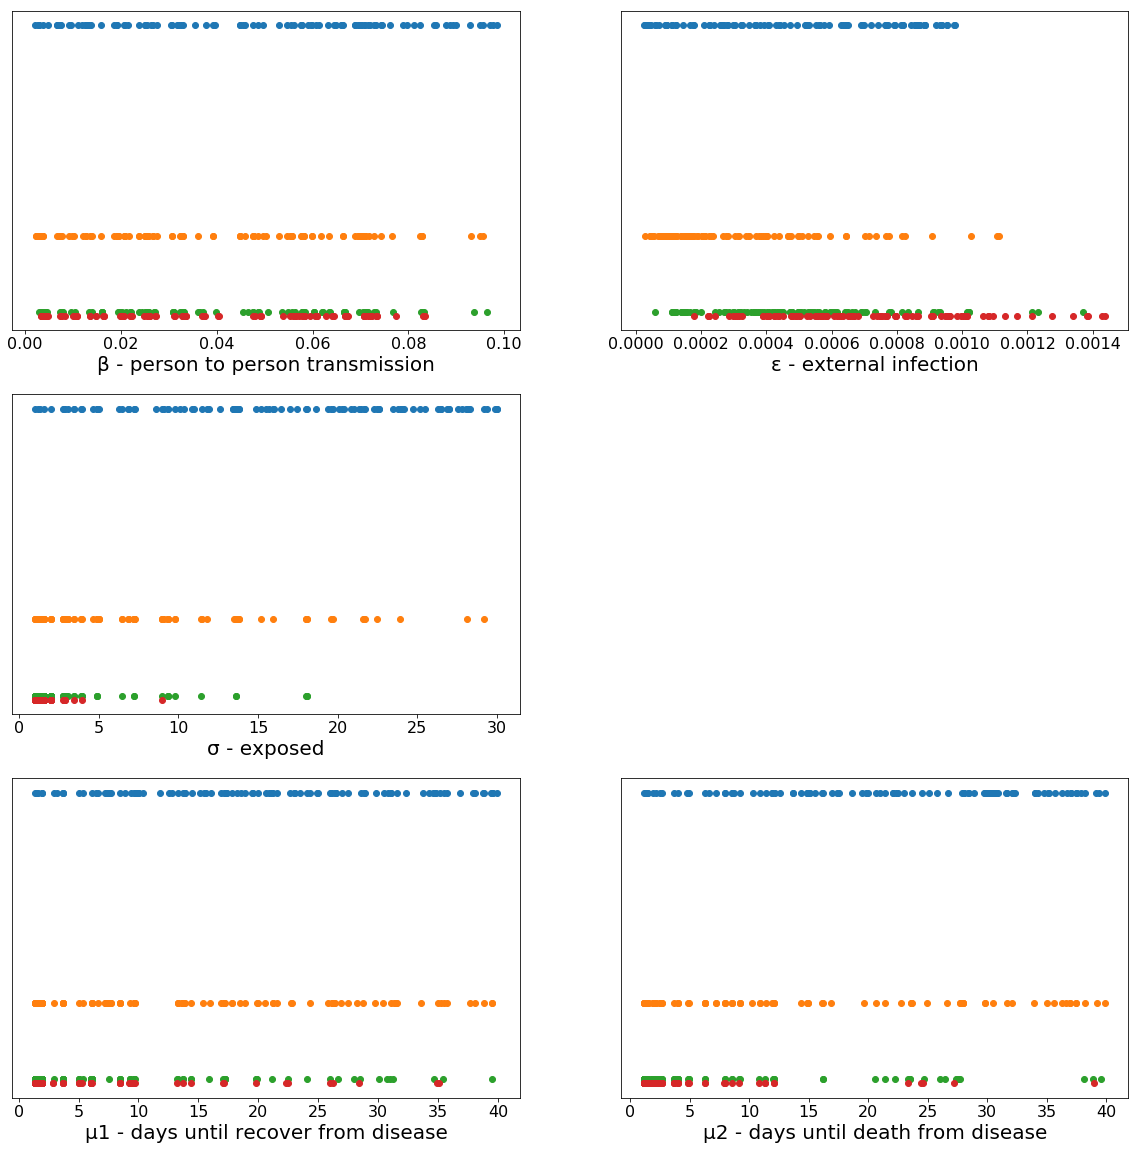

In [43]:
plt.figure(figsize = (20,20))
tol = 4
for i in range(4):
    plt.subplot(3,2,1)
    plt.plot(θ[i][:,0], tols[i]*np.ones(N), 'o' )
    plt.xlabel('β - person to person transmission', fontsize = 20)
    plt.yticks([])
    plt.xticks(fontsize = 16)
    
    plt.subplot(3,2,2)
    plt.plot(θ[i][:,1], tols[i]*np.ones(N), 'o' )
    plt.xlabel('ɛ - external infection', fontsize = 20)
    plt.yticks([])
    plt.xticks(fontsize = 16)

    plt.subplot(3,2,3)
    plt.plot([1/a for a in θ[i][:,2]], tols[i]*np.ones(N), 'o' )
    plt.xlabel('σ - exposed', fontsize = 20)
    plt.yticks([])
    plt.xticks(fontsize = 16)

    plt.subplot(3,2,5)
    plt.plot([1/b for b in θ[i][:,3]] , tols[i]*np.ones(N), 'o' )
    plt.xlabel('μ1 - days until recover from disease', fontsize = 20)
    plt.yticks([])        
    plt.xticks(fontsize = 16)

    plt.subplot(3,2,6)
    plt.plot([1/b for b in θ[i][:,4]] , tols[i]*np.ones(N), 'o' )
    plt.xlabel('μ2 - days until death from disease', fontsize = 20)
    plt.yticks([])        
    plt.xticks(fontsize = 16)
    
#     tol -=1

/home/emma/.local/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


(array([-20., -10.,   0.,  10.,  20.,  30.,  40.,  50.,  60.]),
 <a list of 9 Text xticklabel objects>)

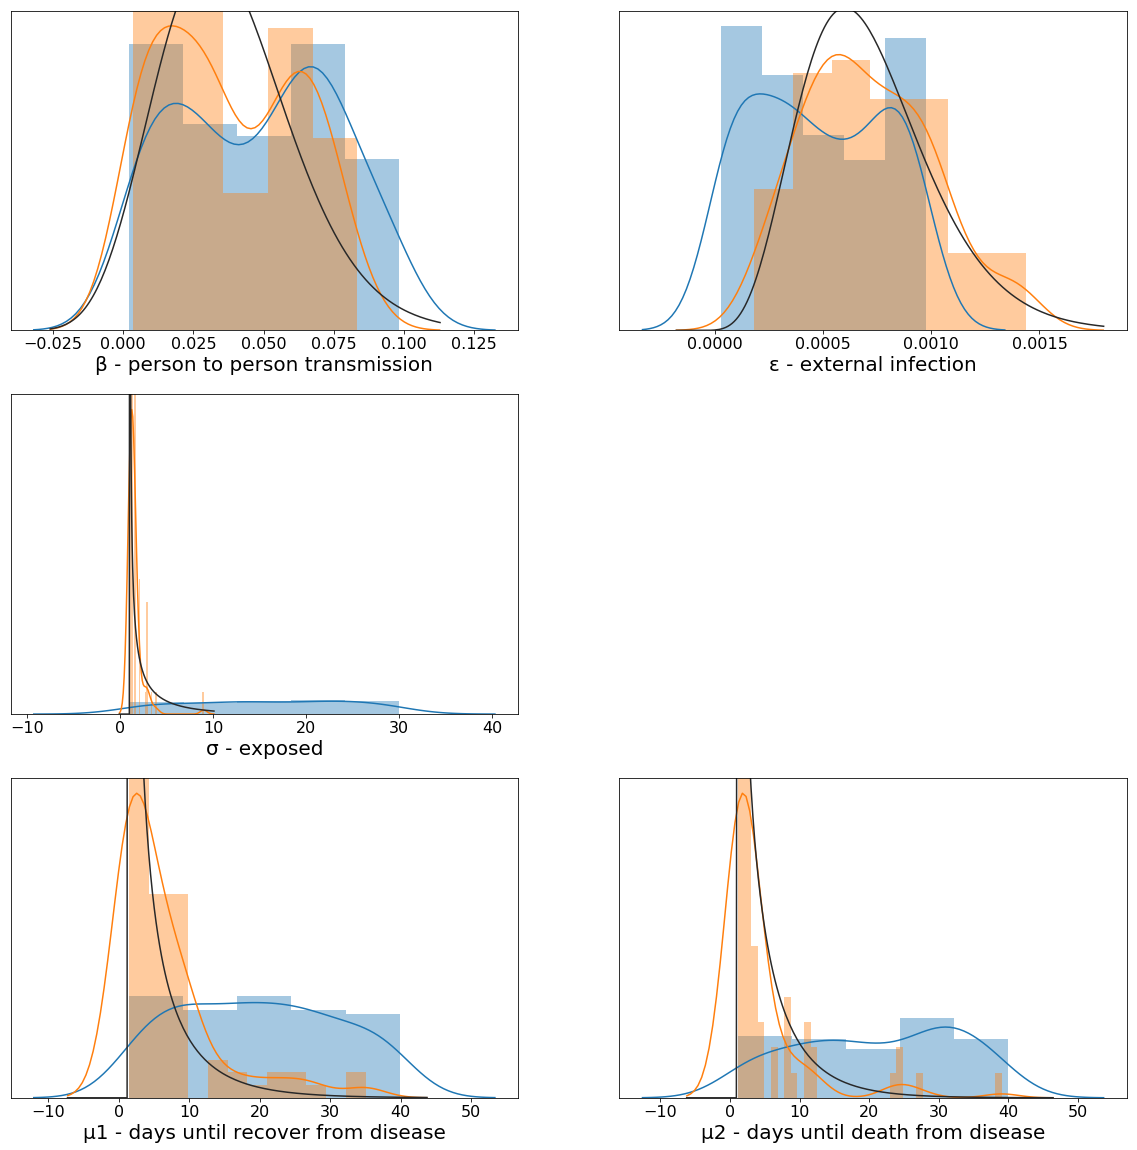

In [45]:
plt.figure(figsize = (20,20))

plt.subplot(3,2,1)
#     plt.plot(θ[i][:,0], tols[i]*np.ones(50), 'o' )
sns.distplot(θ[0][:,0],  kde=True,  norm_hist=False, label = 'Prior')
sns.distplot(θ[3][:,0],  kde=True,  norm_hist=False, fit=stats.gamma, label = 'Posterior')
plt.xlabel('β - person to person transmission', fontsize = 20)
plt.yticks([])
plt.xticks(fontsize = 16)

plt.subplot(3,2,2)
#     plt.plot(θ[i][:,1], tols[i]*np.ones(50), 'o' )
sns.distplot(θ[0][:,1],  kde=True,  norm_hist=False, label = 'Prior')
sns.distplot(θ[3][:,1],  kde=True,  norm_hist=False, fit=stats.gamma, label = 'Posterior')
plt.xlabel('ɛ - external infection', fontsize = 20)
plt.yticks([])
plt.xticks(fontsize = 16)

plt.subplot(3,2,3)
#     plt.plot([1/a for a in θ[i][:,2]], tols[i]*np.ones(50), 'o' )
sns.distplot([1/a for a in θ[0][:,2]],  kde=True,  norm_hist=False, label = 'Prior')
sns.distplot([1/a for a in θ[3][:,2]],  kde=True,  norm_hist=False, fit=stats.gamma, label = 'Posterior')
plt.xlabel('σ - exposed', fontsize = 20)
plt.yticks([])
plt.xticks(fontsize = 16)

plt.subplot(3,2,5)
sns.distplot([1/a for a in θ[0][:,3]],  kde=True,  norm_hist=False, label = 'Prior')
sns.distplot([1/a for a in θ[3][:,3]],  kde=True,  norm_hist=False, fit=stats.gamma, label = 'Posterior')
# plt.plot([1/b for b in θ[i][:,3]] , tols[i]*np.ones(100), 'o' )
plt.xlabel('μ1 - days until recover from disease', fontsize = 20)
plt.yticks([])        
plt.xticks(fontsize = 16)

plt.subplot(3,2,6)
#     plt.plot([1/b for b in θ[i][:,4]] , tols[i]*np.ones(50), 'o' )
sns.distplot([1/a for a in θ[0][:,4]],  kde=True,  norm_hist=False, label = 'Prior')
sns.distplot([1/a for a in θ[3][:,4]],  kde=True,  norm_hist=False, fit=stats.gamma, label = 'Posterior')
plt.xlabel('μ2 - days until death from disease', fontsize = 20)
plt.yticks([])        
plt.xticks(fontsize = 16)

In [ ]:
θ[0][:,4]

In [ ]:
1/np.random.uniform(1/40, 1, N)

In [ ]:
mu = 1/(71*365)
beta, epsilon, sigma, mu1, mu2 = np.mean(θ[5], axis = 0)

In [ ]:
r0 = (beta*sigma)/((sigma+mu)*(mu1 + mu2 + mu))
r0